In [1]:
import pytz
import os
import sqlite3
import re
import uproot
import IPython
import sys
import numpy as np
import pandas as pd
import pymap3d as pm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from cycler import cycler
from pandasql import sqldf
from rnog_data.runtable import RunTable
from datetime import datetime, timedelta
from scipy.fft import fft
from scipy.signal import stft
from NuRadioReco.modules.io.RNO_G.readRNOGDataMattak import readRNOGData
from NuRadioReco.utilities import units
from Flight import Flight
from IPython.display import clear_output

from FlightTracker import FlightTracker

In [2]:
start_time='2021-01-01 00:00:00'
stop_time='2022-01-01 00:00:00'
tracker_2021 = FlightTracker(start_time, stop_time, destination='./flights/flights_2021.db', already_calculated=True)

print(len(tracker_2021.flights), len(tracker_2021.flights_distinct))

324573 2224


In [3]:
start_time='2022-01-01 00:00:00'
stop_time='2023-01-01 00:00:00'
tracker_2022 = FlightTracker(start_time, stop_time, destination='./flights/flights_2022.db', already_calculated=True)

print(len(tracker_2022.flights), len(tracker_2022.flights_distinct))

1383536 8745


In [4]:
start_time='2023-01-01 00:00:00'
stop_time='2024-01-01 00:00:00'
tracker_2023 = FlightTracker(start_time, stop_time, destination='./flights/flights_2023.db', already_calculated=True)

print(len(tracker_2023.flights), len(tracker_2023.flights_distinct))

1013593 6205


In [5]:
start_time='2024-01-01 00:00:00'
stop_time='2025-01-01 00:00:00'
tracker_2024 = FlightTracker(start_time, stop_time, destination='./flights/flights_2024.db', already_calculated=True)

print(len(tracker_2024.flights), len(tracker_2024.flights_distinct))

543817 3526


## concatenate flights, flights_distinct with all data

In [6]:
flights = pd.concat([tracker_2021.flights, tracker_2022.flights, tracker_2023.flights, tracker_2024.flights])
flights_distinct = pd.concat([tracker_2021.flights_distinct, tracker_2022.flights_distinct, tracker_2023.flights_distinct, tracker_2024.flights_distinct])

In [7]:
min_time = flights_distinct.date.min()
max_time = flights_distinct.date.max()

print(min_time)
print(max_time)

2021-06-16
2024-06-17


In [8]:
# add some more fields
flights_distinct = sqldf('SELECT *, substr(flightnumber, 1, 3) as airline FROM flights_distinct')
flights_distinct['datetime_date'] = pd.to_datetime(flights_distinct.date)
flights_distinct['iso_day'] = flights_distinct.datetime_date.dt.isocalendar().day
flights_distinct['iso_month'] = flights_distinct.datetime_date.dt.month
flights_distinct['iso_year'] = flights_distinct.datetime_date.dt.year

In [9]:
# save the stuff
con = sqlite3.connect(f'./flights/flights_ALL')

# Write the DataFrame to the SQLite database
flights.to_sql(f'flights', con)
flights_distinct.to_sql(f'flights_distinct', con)

# Close the database connection
con.close()

ValueError: Table 'flights' already exists.

In [ ]:
# save the stuff
con = sqlite3.connect(f'./flights/flights_ALL')

# Write the DataFrame to the SQLite database
r = pd.read_sql_query('Select name from sqlite_master where type = "table"', con)

# Close the database connection
con.close()
print(r)

               name
0           flights
1  flights_distinct


In [2]:
con = sqlite3.connect(f'./flights/flights_ALL')

# Write the DataFrame to the SQLite database
flights = pd.read_sql_query('Select * from flights', con)
flights_distinct = pd.read_sql_query('Select * from flights_distinct', con)

# Close the database connection
con.close()
min_time = flights_distinct.date.min()
max_time = flights_distinct.date.max()

print(min_time)
print(max_time)

2021-06-16
2024-06-17


## Number of flights per airline (in radius)

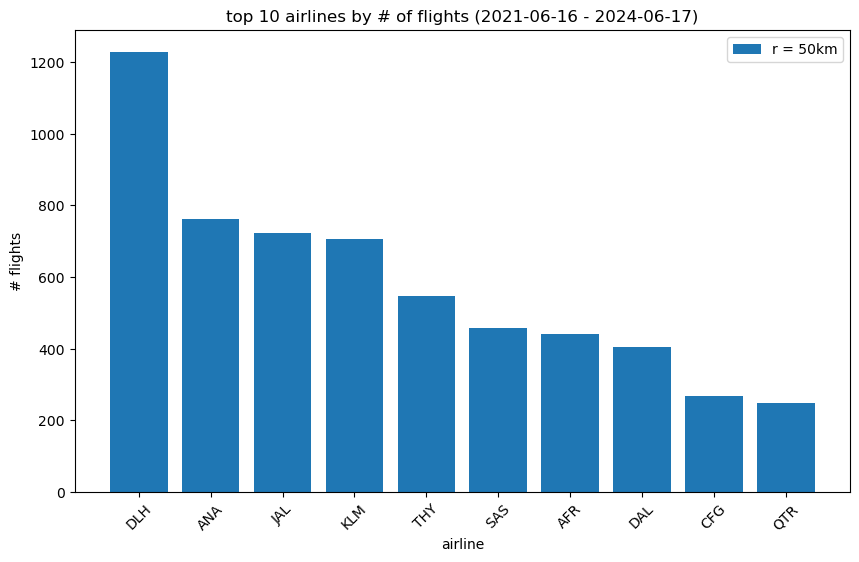

In [16]:
radius = 50
query = f'''
SELECT 
    airline
    ,count(airline) as count
FROM (
    SELECT 
        substr(flightnumber, 1, 3) as airline 
    FROM flights_distinct
    WHERE min_r < {radius}
)t0
GROUP BY airline
ORDER BY count(airline) desc

'''


result = sqldf(query)
top_10 = result.head(10)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(top_10['airline'], top_10['count'], label ='r = 50km')
plt.title(f'top 10 airlines by # of flights ({min_time} - {max_time})')
plt.legend()
plt.xlabel('airline')
plt.ylabel('# flights')
plt.xticks(rotation=45)
plt.show()
#plt.savefig(f'saved_figures/top_10_airlines_50km_{min_time}_{max_time}.pdf')

In [17]:
result.head(40)

,airline,count
0,DLH,1228
1,ANA,762
2,JAL,724
3,KLM,705
4,THY,548
5,SAS,457
6,AFR,441
7,DAL,405
8,CFG,268
9,QTR,249


In [5]:
radius = 50
query = f'''
SELECT 
    airline
    ,min(theta) as min_theta
    ,max(theta) as max_theta
FROM (
    SELECT 
        substr(flightnumber, 1, 3) as airline 
        ,theta
    FROM flights_distinct
    WHERE min_r < {radius}
)t0
--Where airline = "DLH"
GROUP BY airline
ORDER BY count(airline) desc

'''


result = sqldf(query)
result

,airline,min_theta,max_theta
0,DLH,1.0,24.0
1,ANA,27.0,40.0
2,JAL,30.0,40.0
3,KLM,2.0,48.0
4,THY,0.0,26.0
...,...,...,...
115,CGE,45.0,45.0
116,CFC,1.0,1.0
117,APF,0.0,0.0
118,ABG,39.0,39.0


## Number of flights per day (for 4 radii)

In [7]:
radii = [150, 100, 50, 25]
symbols = ['s', 'o', 'x', 'v']

cycler = zip(radii, symbols)

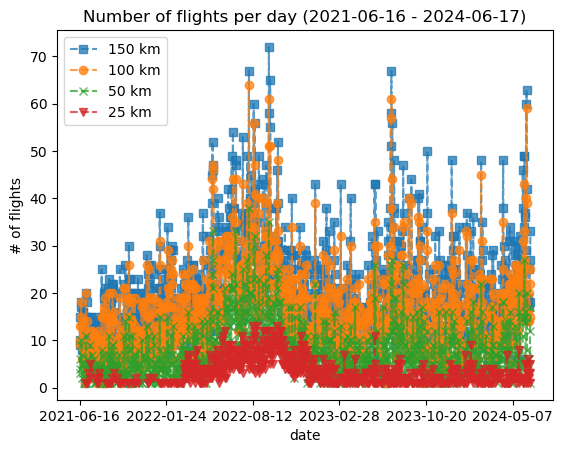

In [8]:
def query(min_r):

    return f'''
    Select 
        date, 
        count(flightnumber) as counter
    from flights_distinct
    Where min_r < {min_r}
    Group By date
    '''

for i, symbol in cycler:
    flights_per_day = sqldf(query(i))
    plt.plot(flights_per_day.date, flights_per_day.counter, symbol, label = f'{i} km', alpha = 0.75, linestyle = '--')
    plt.title(f'Number of flights per day ({min_time} - {max_time})')
plt.xlabel('date')
plt.ylabel('# of flights')
plt.legend()
#plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
#plt.savefig(f'saved_figures/flights_per_day_all.pdf')

In [9]:
linestyle = ['--', '--', '--', '--', '--', '--']
marker = ['o', 's', 'D', '^', 'v', 'x']

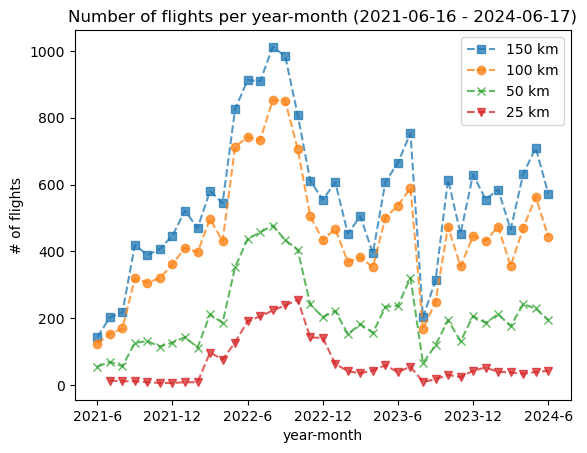

In [10]:
def query(min_r):

    return f'''
    Select 
        year_month
        ,count(flightnumber) as counter
    from (
        Select 
            iso_year || '-' || iso_month as year_month
            ,iso_year
            ,iso_month
            ,flightnumber
        from flights_distinct
        Where min_r < {min_r}
    )t0
    Group By year_month
    Order By iso_year, iso_month
    '''

radii = [150, 100, 50, 25]
symbols = ['s', 'o', 'x', 'v']

cycler = zip(radii, symbols)

for i, symbol in cycler:
    flights_per_day = sqldf(query(i))
    #date_min = flights_per_day.date.min()
    #date_max = flights_per_day.date.max()
    plt.plot(flights_per_day.year_month, flights_per_day.counter, symbol, label = f'{i} km', alpha = 0.75, linestyle = '--')
    plt.title(f'Number of flights per year-month ({min_time} - {max_time})')

plt.xlabel('year-month')
plt.ylabel('# of flights')
plt.legend()
# Customizing the x-axis to show Mo-Su
#years = ['2020', '2021', '2022', '2023', '2024']
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=7))
#plt.gca().xaxis.set_major_locator(ticker.FixedLocator(range(1, 6)))
#plt.gca().xaxis.set_major_formatter(ticker.FixedFormatter(years))

#plt.savefig(f'saved_figures/flights_per_year_month_{date_min}_{date_max}.pdf')

In [11]:
flights_per_day.year_month.unique()

array(['2021-7', '2021-8', '2021-9', '2021-10', '2021-11', '2021-12',
       '2022-1', '2022-2', '2022-3', '2022-4', '2022-5', '2022-6',
       '2022-7', '2022-8', '2022-9', '2022-10', '2022-11', '2022-12',
       '2023-1', '2023-2', '2023-3', '2023-4', '2023-5', '2023-6',
       '2023-7', '2023-8', '2023-9', '2023-10', '2023-11', '2023-12',
       '2024-1', '2024-2', '2024-3', '2024-4', '2024-5', '2024-6'],
      dtype=object)

## Number of flights per weekday (4 radii)

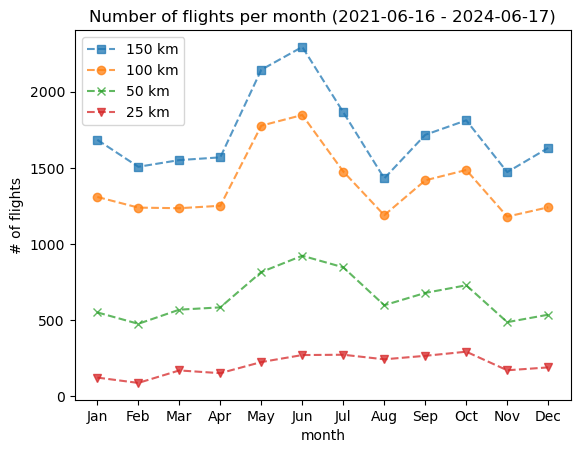

In [12]:
def query(min_r):

    return f'''
    Select 
        iso_month, 
        count(flightnumber) as counter
    from flights_distinct
    Where min_r < {min_r}
    Group By iso_month
    '''
radii = [150, 100, 50, 25]
symbols = ['s', 'o', 'x', 'v']

cycler = zip(radii, symbols)

for i, symbol in cycler:
    flights_per_day = sqldf(query(i))
    plt.plot(flights_per_day.iso_month, flights_per_day.counter, symbol, linestyle = '--', label = f'{i} km', alpha = 0.75)
    plt.title(f'Number of flights per month ({min_time} - {max_time})')
plt.xlabel('month')
plt.ylabel('# of flights')
plt.legend()
# Customizing the x-axis to show Mo-Su
months_of_year = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.gca().xaxis.set_major_locator(ticker.FixedLocator(range(1, 13)))
plt.gca().xaxis.set_major_formatter(ticker.FixedFormatter(months_of_year))

#plt.savefig('saved_figures/flights_per_month_all.pdf')

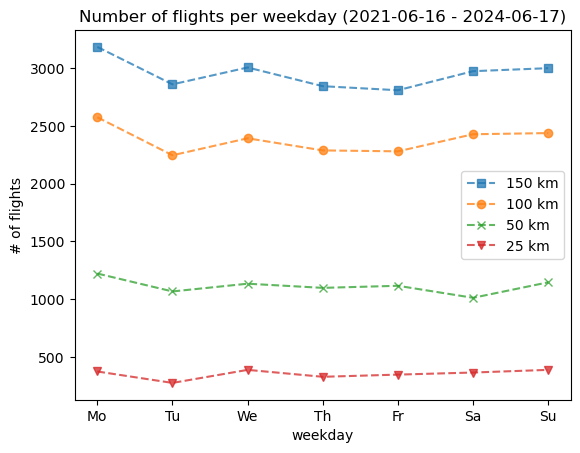

In [13]:
def query(min_r):

    return f'''
    Select 
        iso_day, 
        count(flightnumber) as counter
    from flights_distinct
    Where min_r < {min_r}
    Group By iso_day
    '''

radii = [150, 100, 50, 25]
symbols = ['s', 'o', 'x', 'v']

cycler = zip(radii, symbols)

for i, symbol in cycler:
    flights_per_day = sqldf(query(i))
    plt.plot(flights_per_day.iso_day, flights_per_day.counter, symbol, linestyle = '--', label = f'{i} km', alpha = 0.75)
    plt.title(f'Number of flights per weekday ({min_time} - {max_time})')
plt.xlabel('weekday')
plt.ylabel('# of flights')
plt.legend()
# Customizing the x-axis to show Mo-Su
days_of_week = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
plt.gca().xaxis.set_major_locator(ticker.FixedLocator([1, 2, 3, 4, 5, 6, 7]))
plt.gca().xaxis.set_major_formatter(ticker.FixedFormatter(days_of_week))
#plt.savefig('saved_figures/flights_per_weekday_all.pdf')

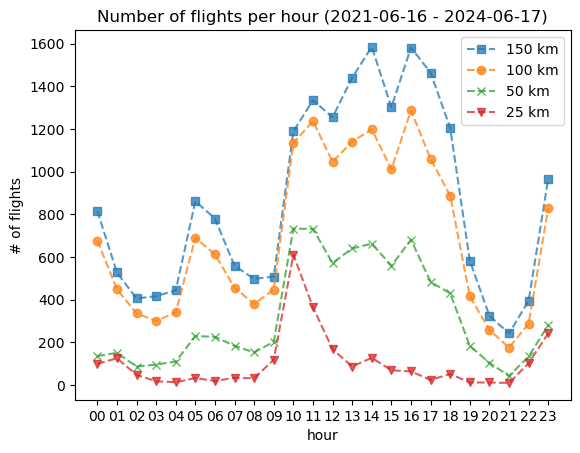

In [14]:
def query(min_r):

    return f'''
    Select 
        strftime('%H', mintime) as hour
        ,count(flightnumber) as counter
    from flights_distinct
    Where min_r < {min_r}
    Group By strftime('%H', mintime)
    '''
radii = [150, 100, 50, 25]
symbols = ['s', 'o', 'x', 'v']

cycler = zip(radii, symbols)

for i, symbol in cycler:
    flights_per_day = sqldf(query(i))
    plt.plot(flights_per_day.hour, flights_per_day.counter, symbol, linestyle = '--', label = f'{i} km', alpha = 0.75)
    plt.title(f'Number of flights per hour ({min_time} - {max_time})')
plt.xlabel('hour')
plt.ylabel('# of flights')
plt.legend()
# Customizing the x-axis to show Mo-Su
#days_of_week = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
#plt.gca().xaxis.set_major_locator(ticker.FixedLocator([1, 2, 3, 4, 5, 6, 7]))
#plt.gca().xaxis.set_major_formatter(ticker.FixedFormatter(days_of_week))
#plt.savefig('saved_figures/flights_per_hour_all.pdf')
#flights_per_day
#flights_per_day